# library 설치 & 데이터 loading

##  Library

In [4]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

##  Data Loading

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Feature Engineering

 CODE SHARE WITH "파베르"님 
 (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)


In [6]:
train=train[train.단지코드!='C1397']

In [7]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(train.groupby('지역')['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].transform('mean'))
train['도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].fillna(train.groupby('지역')['도보 10분거리 내 버스정류장 수'].transform('mean'))
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(test.groupby('지역')['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].transform('mean'))


#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

In [8]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대/장기전세,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대/장기전세,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대/장기전세,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대/장기전세,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대/장기전세,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대/장기전세,49.20,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대/장기전세,51.08,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대/장기전세,51.73,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대/장기전세,51.96,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0


In [9]:
codes = train.단지코드.unique()
#train
for code in codes:
    temp_by_code = train.loc[train.단지코드==code].reset_index(drop=True)
    if(temp_by_code[temp_by_code.임대보증금!=0].shape[0]==0):
            X_train.loc[code,"임대보증금"]=0
    else:
            X_train.loc[code,"임대보증금"]=round(temp_by_code.임대보증금.sum()/temp_by_code[temp_by_code.임대보증금!=0].shape[0])
        
    if(temp_by_code[temp_by_code.임대료!=0].shape[0]==0):
            X_train.loc[code,"임대료"]=0
    else:
            X_train.loc[code,"임대료"]=round(temp_by_code.임대료.sum()/temp_by_code[temp_by_code.임대료!=0].shape[0])
#test
codes=test.단지코드.unique()
for code in codes:
    temp_by_code = test.loc[test.단지코드==code].reset_index(drop=True)
    if(temp_by_code[temp_by_code.임대보증금!=0].shape[0]==0):
            X_test.loc[code,"임대보증금"]=0
    else:
            X_test.loc[code,"임대보증금"]=round(temp_by_code.임대보증금.sum()/temp_by_code[temp_by_code.임대보증금!=0].shape[0])
        
    if(temp_by_code[temp_by_code.임대료!=0].shape[0]==0):
            X_test.loc[code,"임대료"]=0
    else:
            X_test.loc[code,"임대료"]=round(temp_by_code.임대료.sum()/temp_by_code[temp_by_code.임대료!=0].shape[0])

In [10]:
X_train

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
C2483,900,경상북도,38.0,0.000000,3.000000,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24776375.0,167910.0
C2515,545,경상남도,17.0,0.000000,3.000000,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16787143.0,139557.0
C1407,1216,대전광역시,13.0,1.000000,1.000000,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25984375.0,165956.0
C1945,755,경기도,6.0,1.000000,3.000000,734.0,730.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24060600.0,200914.0
C1470,696,전라북도,14.0,0.000000,2.000000,645.0,553.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17722750.0,120150.0
C1898,566,전라북도,9.0,0.000000,6.000000,517.0,415.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17422333.0,119148.0
C1244,1722,경기도,10.0,0.000000,10.000000,1483.0,1804.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,40338727.0,276856.0
C1171,624,대전광역시,13.0,0.000000,5.000000,634.0,700.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,31163364.0,174082.0
C2073,361,강원도,13.0,0.000000,5.000000,288.0,301.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16220333.0,198050.0
C2513,754,광주광역시,15.0,0.000000,6.000000,530.0,820.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32443000.0,192250.0


 * Feature Engineering
   필요성?

In [11]:
X_train.head(3)

# 1. 지역은 글자데이터이다.
## 한글은 Catboost 이외에는 받아들일 수 없기  때문에, Encoding 과정이 필요하다.
## 해결법  : 통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24776375.0,167910.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16787143.0,139557.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25984375.0,165956.0


In [12]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 단순 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.0,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,4.220000e+02,422.000000
mean,723.222749,13.490521,0.134551,3.701006,590.381517,569.912322,0.078199,1.0,0.026066,0.090047,0.741706,0.132701,0.078199,0.073460,0.784360,0.080569,0.116114,0.130332,0.073460,2.416568e+07,187993.888626
std,405.707479,10.395443,0.388482,2.805790,364.860933,388.303478,0.268803,0.0,0.159522,0.286589,0.438216,0.339654,0.268803,0.261199,0.411754,0.272495,0.320742,0.337068,0.261199,1.543909e+07,117651.161952
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,450.250000,5.000000,0.000000,2.000000,319.250000,294.500000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.484535e+07,116539.000000
50%,632.000000,13.000000,0.000000,3.000000,522.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.994567e+07,155281.000000
75%,923.500000,20.000000,0.000000,4.000000,798.500000,761.750000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.959248e+07,220598.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.118005e+08,970947.000000


In [13]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

-  이상치가 보인다

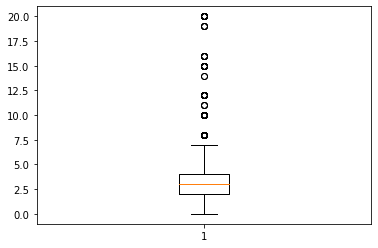

In [14]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [15]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.000000    370
0.722543      8
1.000000     38
2.000000      5
3.000000      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.000000    137
1.000000      8
1.276596      2
2.000000      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.000000    370
0.722543      8
1.000000     38
2.000000      5
Name: 총세대수, dtype: int64

In [16]:
corr = X_train.corr()["등록차량수"].abs().sort_values(ascending=False)
corr

등록차량수                           1.000000
단지내주차면수                         0.845273
총세대수                            0.588940
임대료                             0.464139
임대보증금                           0.412300
공급유형_공공임대(5년/10년/분납/분양)         0.412057
공급유형_임대상가                       0.316983
임대건물구분_상가                       0.316983
자격유형_D                          0.273482
자격유형_A                          0.236512
공급유형_영구임대                       0.204944
자격유형_영구임대_공급대상                  0.200284
공가수                             0.175044
공급유형_행복주택                       0.171081
자격유형_행복주택_공급대상                  0.171081
도보 10분거리 내 버스정류장 수              0.114034
공급유형_공공임대(50년)                  0.110722
자격유형_국민임대/장기전세_공급대상             0.106427
공급유형_국민임대/장기전세                  0.065007
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0.010890
Name: 등록차량수, dtype: float64

# Encoding & scailing

## Encoding

In [17]:
X_train.head(3)

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24776375.0,167910.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16787143.0,139557.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25984375.0,165956.0


In [18]:
from sklearn.preprocessing import LabelEncoder

features=['지역']

encoder=LabelEncoder()
X_train['지역']=encoder.fit_transform(X_train['지역'])
X_test['지역']=encoder.transform(X_test['지역'])

In [19]:
X_test.지역.value_counts()

1     36
0     15
2     14
15    12
3     10
12     9
10     9
7      8
4      7
13     6
6      6
5      6
14     5
11     4
9      3
Name: 지역, dtype: int64

In [20]:
X_train.head(5)

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
C2483,900,3,38.0,0.0,3.0,1425.0,1015.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24776375.0,167910.0
C2515,545,2,17.0,0.0,3.0,624.0,205.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16787143.0,139557.0
C1407,1216,6,13.0,1.0,1.0,1285.0,1064.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25984375.0,165956.0
C1945,755,1,6.0,1.0,3.0,734.0,730.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24060600.0,200914.0
C1470,696,12,14.0,0.0,2.0,645.0,553.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17722750.0,120150.0


## Scailing

In [21]:
X_train.loc[:,-['임대건물구분_상가':'자격유형_행복주택_공급대상']].describe()

SyntaxError: invalid syntax (<ipython-input-21-5de377b91c7f>, line 1)

In [ ]:
scailing_features = ['총세대수','지역','공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)','임대료','임대보증금']

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

In [ ]:
X_train.describe()

# pycaret

In [22]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(421, 21)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,0
6,Transformed Train Set,"(420, 20)"
7,Transformed Test Set,"(1, 20)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [23]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,125.6702,35672.4998,184.8816,0.7492,0.4195,0.3736,2.7920
ridge,Ridge Regression,128.9767,34160.7383,182.9275,0.7503,0.4399,0.3525,0.0240
lasso,Lasso Regression,129.1371,34014.9248,182.4905,0.7510,0.4430,0.3544,0.0230
llar,Lasso Least Angle Regression,130.0567,35221.6598,185.1249,0.7450,0.4062,0.3873,0.0220
en,Elastic Net,131.8744,35441.2211,186.1203,0.7419,0.4461,0.3696,0.0410
et,Extra Trees Regressor,131.9576,37846.1405,191.9710,0.7263,0.3627,0.3248,0.2390
rf,Random Forest Regressor,132.4954,40205.9381,196.7735,0.7123,0.3765,0.3375,0.2580
gbr,Gradient Boosting Regressor,132.7037,39705.6095,195.4745,0.7197,0.4494,0.3707,0.0560
br,Bayesian Ridge,133.2940,36404.0425,188.2535,0.7325,0.4032,0.3735,0.0340
lar,Least Angle Regression,133.3809,36416.7921,189.4818,0.7352,0.4447,0.4006,0.0310


In [24]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,91.5370,19576.3848,139.9156,0.8645,0.5317,0.2414
1,145.4026,42664.1289,206.5530,0.5122,0.4659,0.4478
2,106.9786,19959.4824,141.2780,0.8293,0.3750,0.3480
3,141.1973,33890.0664,184.0925,0.7740,0.5817,0.2806
4,133.8373,33226.9648,182.2827,0.6203,0.4731,0.3437
5,160.4992,51568.6562,227.0873,0.7427,0.4977,0.4946
6,118.3184,47167.4414,217.1807,0.7115,0.3241,0.2529
7,134.9320,33252.1328,182.3517,0.8417,0.3457,0.2860
8,135.9547,32727.2617,180.9068,0.7669,0.4339,0.4117
9,120.7821,29642.1367,172.1689,0.8305,0.4345,0.3847


In [26]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)
sample = pd.read_csv('sample_submission.csv')
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
sample.to_csv('submissions/pycaret.csv', index=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,81.3604,16641.7231,129.0028,0.8849,0.3712,0.2691
1,138.0173,39940.9430,199.8523,0.5433,0.4424,0.4090
2,95.1780,15529.4362,124.6172,0.8672,0.5680,0.2984
3,136.5696,33216.7814,182.2547,0.7784,0.2962,0.2478
4,126.7853,29297.5178,171.1652,0.6652,0.4296,0.3159
5,152.3966,48062.3830,219.2313,0.7602,0.4820,0.4959
6,111.3288,42048.5921,205.0575,0.7428,0.2997,0.2286
7,128.4411,31408.8554,177.2254,0.8505,0.3256,0.2674
8,137.3106,35286.1123,187.8460,0.7487,0.4350,0.4067
9,120.0146,33491.2948,183.0063,0.8085,0.4458,0.4225


# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [51]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

- Hyper params Tuning

In [52]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [53]:
X.head(3)

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,임대보증금,임대료
C2483,0.433782,-0.521871,2.364652,-0.352448,-0.249593,2.287602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.043102,-0.167260
C2515,-0.442418,-0.721243,0.341045,-0.352448,-0.249593,0.090060,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.475662,-0.409077
C1407,1.213723,0.076244,-0.044404,2.406562,-0.962414,1.903512,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.121540,-0.183926


In [54]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-27 23:03:18,108] A new study created in memory with name: cat_opt
[I 2021-07-27 23:03:18,683] Trial 0 finished with value: 134.65053276398635 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 134.65053276398635.
[I 2021-07-27 23:03:19,059] Trial 1 finished with value: 139.3509870392582 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 134.65053276398635.
[I 2021-07-27 23:03:19,599] Trial 2 finished with value: 128.18992018208775 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 2 with value: 128.18992018208775.
[I 2021-07-27 23:03:19,962] Trial 3 finished with value: 114.03099304381705 and parameters: {'max_depth':

Best Score: 114.03099304381705
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8608484485919076, 'subsample': 0.6673295021425665, 'min_child_samples': 46, 'max_bin': 287}


In [55]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [56]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [57]:
sample = pd.read_csv('sample_submission.csv')
sample['num'] = cat_pred
sample.to_csv('submissions/cat2_new.csv', index=False)